In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os
import numpy as np
import glob
from modelzipper.tutils import *
from matplotlib.colors import ListedColormap, BoundaryNorm

/mnt/petrelfs/tangzecheng/anaconda3/envs/zecheng_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModelZipper is ready for launch🚀 | Current Version🦄 >>> 0.2.7 <<< | AOE Time🕒 2024-12-13 17:12:44


In [2]:
hop_files = auto_read_dir("/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/head_score/6-hop", file_prefix='*_Meta')
print(hop_files)

fail_head_score = auto_read_data(hop_files[0])
succ_head_score = auto_read_data(hop_files[1])

2024-12-13 13:12:47.585 | INFO     | modelzipper.tutils:auto_read_dir:325 - number of files with prefix '*_Meta' and suffix '': 4
2024-12-13 13:12:47.588 | INFO     | modelzipper.tutils:auto_read_data:182 - begin to read data from /mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/head_score/6-hop/fail_Meta-Llama-3-8B-Instruct.json | file size: 3.84 MB | file type: json


['/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/head_score/6-hop/fail_Meta-Llama-3-8B-Instruct.json', '/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/head_score/6-hop/fail_Meta-Llama-3.1-8B-Instruct.json', '/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/head_score/6-hop/success_Meta-Llama-3-8B-Instruct.json', '/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/head_score/6-hop/success_Meta-Llama-3.1-8B-Instruct.json']


2024-12-13 13:12:47.884 | INFO     | modelzipper.tutils:auto_read_data:182 - begin to read data from /mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/head_score/6-hop/fail_Meta-Llama-3.1-8B-Instruct.json | file size: 3.66 MB | file type: json


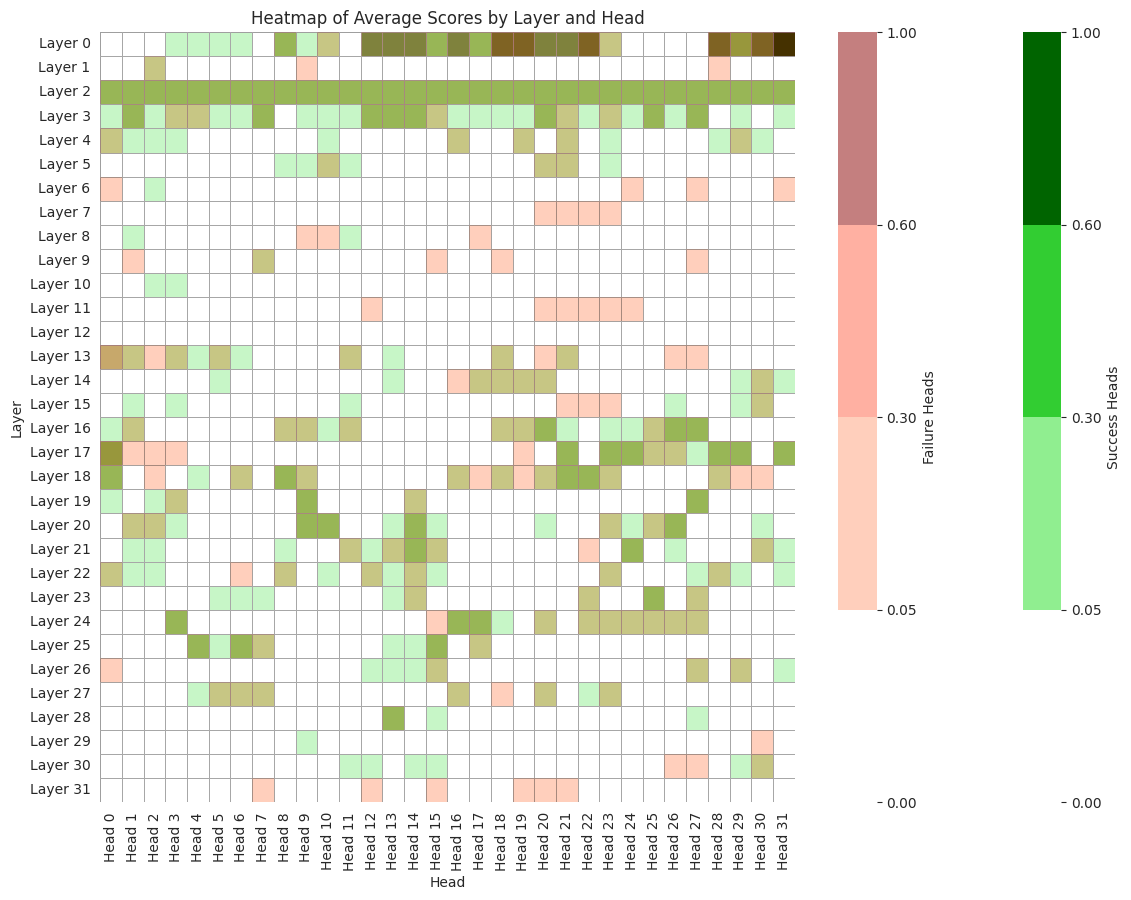

In [9]:
num_layers = 32
num_heads = 32
df_succ_scores = np.zeros((num_layers, num_heads))
df_fail_scores = np.zeros((num_layers, num_heads))

for key, values in succ_head_score.items():
    layer, head = map(int, key.split('-'))
    df_succ_scores[layer, head] = np.mean(values)

for key, values in fail_head_score.items():
    layer, head = map(int, key.split('-'))
    df_fail_scores[layer, head] = np.mean(values)

colors1 = ['#ffffff', '#90ee90', '#32cd32', '#006400']  # 浅绿 -> 中绿 -> 深绿
colors2 = ['#ffffff', '#ffa07a', '#ff6347', '#8b0000']  # 浅红 -> 中红 -> 深红
bounds = [0, 0.05, 0.3, 0.6, 1.0]  # 定义边界

# 创建colormap和norm
cmap1 = ListedColormap(colors1)
cmap2 = ListedColormap(colors2)
norm = BoundaryNorm(bounds, len(colors1))

# 转换为 DataFrame
df_succ_scores = pd.DataFrame(df_succ_scores, columns=[f'Head {i}' for i in range(num_heads)], 
                  index=[f'Layer {i}' for i in range(num_layers)])
df_fail_scores = pd.DataFrame(df_fail_scores, columns=[f'Head {i}' for i in range(num_heads)], 
                  index=[f'Layer {i}' for i in range(num_layers)])

sns.set_style("white")

fail_column_means = df_fail_scores.mean() # 计算每列的平均分
succ_column_means = df_succ_scores.mean()

# 使用apply函数，沿着列的方向（axis=0）应用一个函数
# 这个函数会检查每一个元素，如果元素值低于其所在列的平均分，那么该元素值将被设置为0
df_succ_scores = df_succ_scores.apply(lambda x: [value if value >= succ_column_means[x.name] else 0 for value in x], axis=0)
df_fail_scores = df_fail_scores.apply(lambda x: [value if value >= fail_column_means[x.name] else 0 for value in x], axis=0)

succ_heads = df_succ_scores 
fail_heads = df_fail_scores 

# 绘制热力图
plt.figure(figsize=(14, 10))

sns.heatmap(succ_heads, cmap=cmap1, norm=norm, alpha=1, cbar=True, 
            cbar_kws={'label': 'Success Heads'}, linewidths=0.5, linecolor='gray')

sns.heatmap(fail_heads, cmap=cmap2, norm=norm, alpha=0.5, cbar=True, 
            cbar_kws={'label': 'Failure Heads'}, linewidths=0.5, linecolor='gray')

plt.title('Heatmap of Average Scores by Layer and Head')
plt.xlabel('Head')
plt.ylabel('Layer')
plt.show()

In [5]:
succ_heads > succ_heads.mean()

,Head 0,Head 1,Head 2,Head 3,Head 4,Head 5,Head 6,Head 7,Head 8,Head 9,...,Head 22,Head 23,Head 24,Head 25,Head 26,Head 27,Head 28,Head 29,Head 30,Head 31
Layer 0,False,False,False,True,True,True,True,False,True,True,...,True,True,False,False,False,False,True,True,True,True
Layer 1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Layer 2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Layer 3,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,False,True,True,True
Layer 4,True,True,True,True,False,False,False,False,False,False,...,False,True,False,False,False,False,True,True,True,False
Layer 5,False,False,False,False,False,False,False,False,True,True,...,False,True,False,False,False,False,False,False,False,False
Layer 6,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Layer 7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Layer 8,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Layer 9,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


下面是分析Reasoning Head 和 Retrieval Head 之间的关系

In [ ]:
# head_reasoning_file = "/data/zecheng/acl2025/MyRLHF/RetrievalHead/reetrievalheaddetect/head_score/q3_inf_diff_pos/Meta-Llama-3.1-8B-Instruct.json"
# head_score_file = "/data/zecheng/acl2025/MyRLHF/RetrievalHead/reetrievalheaddetect/head_score/niah_retrieval/Meta-Llama-3.1-8B-Instruct.json"
head_reasoning_file = "/data/zecheng/acl2025/MyRLHF/reetrievalheaddetect/head_score/q3_inf_diff_pos/Qwen2.5-7B-Instruct.json"
head_score_file = "/data/zecheng/acl2025/MyRLHF/reetrievalheaddetect/head_score/niah_retrieval/Qwen2.5-7B-Instruct.json"
reason_scores = auto_read_data(head_reasoning_file)
retrieval_scores = auto_read_data(head_score_file)

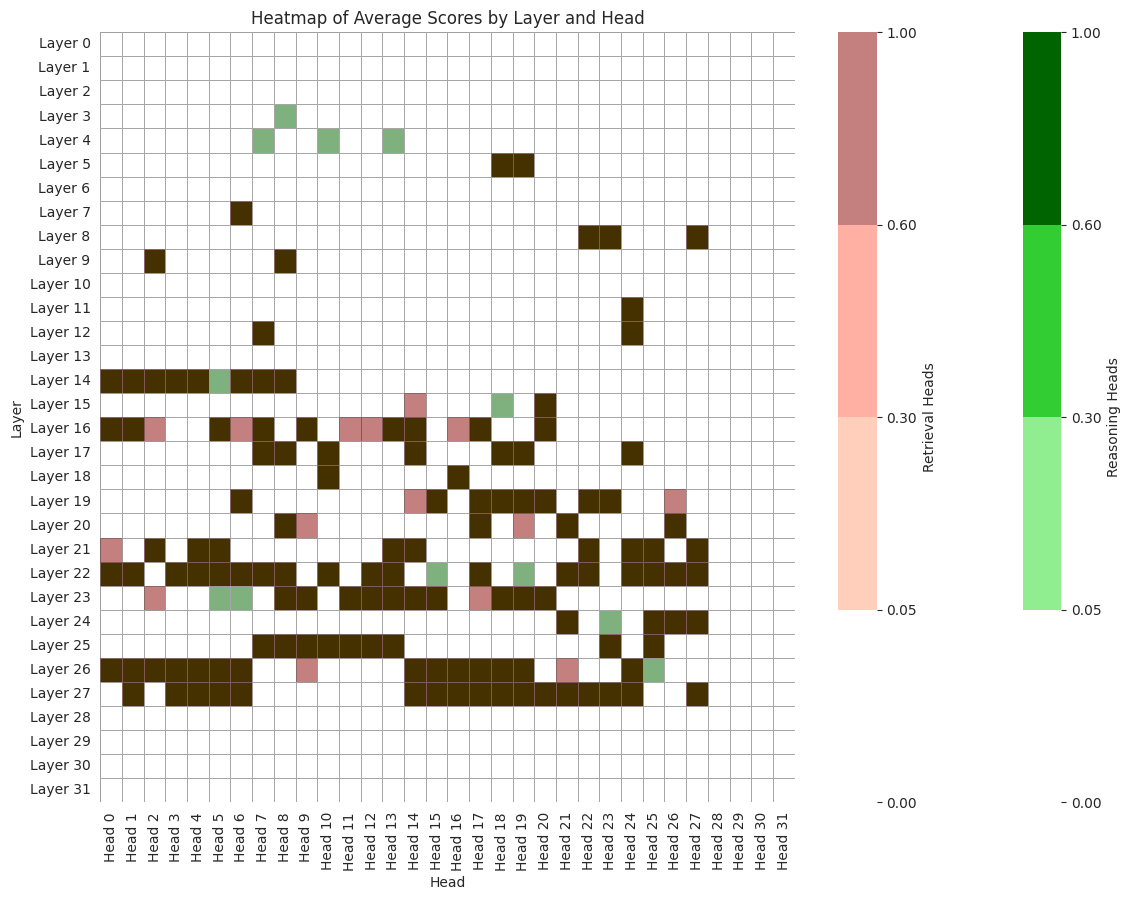

In [6]:
num_layers = 32
num_heads = 32
df_reason_scores = np.zeros((num_layers, num_heads))
df_retrieval_scores = np.zeros((num_layers, num_heads))

for key, values in reason_scores.items():
    layer, head = map(int, key.split('-'))
    df_reason_scores[layer, head] = np.mean(values)

for key, values in retrieval_scores.items():
    layer, head = map(int, key.split('-'))
    df_retrieval_scores[layer, head] = np.mean(values)

colors1 = ['#ffffff', '#90ee90', '#32cd32', '#006400']  # 浅绿 -> 中绿 -> 深绿
colors2 = ['#ffffff', '#ffa07a', '#ff6347', '#8b0000']  # 浅红 -> 中红 -> 深红
bounds = [0, 0.05, 0.3, 0.6, 1.0]  # 定义边界

# 创建colormap和norm
cmap1 = ListedColormap(colors1)
cmap2 = ListedColormap(colors2)
norm = BoundaryNorm(bounds, len(colors1))

# 转换为 DataFrame
df_reason_scores = pd.DataFrame(df_reason_scores, columns=[f'Head {i}' for i in range(num_heads)], 
                  index=[f'Layer {i}' for i in range(num_layers)])
df_retrieval_scores = pd.DataFrame(df_retrieval_scores, columns=[f'Head {i}' for i in range(num_heads)], 
                  index=[f'Layer {i}' for i in range(num_layers)])

sns.set_style("white")

reasoning_heads = df_reason_scores > 0.1
retrieval_heads = df_retrieval_scores > 0.1

# 绘制热力图
plt.figure(figsize=(14, 10))

sns.heatmap(reasoning_heads, cmap=cmap1, norm=norm, alpha=1, cbar=True, 
            cbar_kws={'label': 'Reasoning Heads'}, linewidths=0.5, linecolor='gray')

sns.heatmap(retrieval_heads, cmap=cmap2, norm=norm, alpha=0.5, cbar=True, 
            cbar_kws={'label': 'Retrieval Heads'}, linewidths=0.5, linecolor='gray')

plt.title('Heatmap of Average Scores by Layer and Head')
plt.xlabel('Head')
plt.ylabel('Layer')
plt.show()

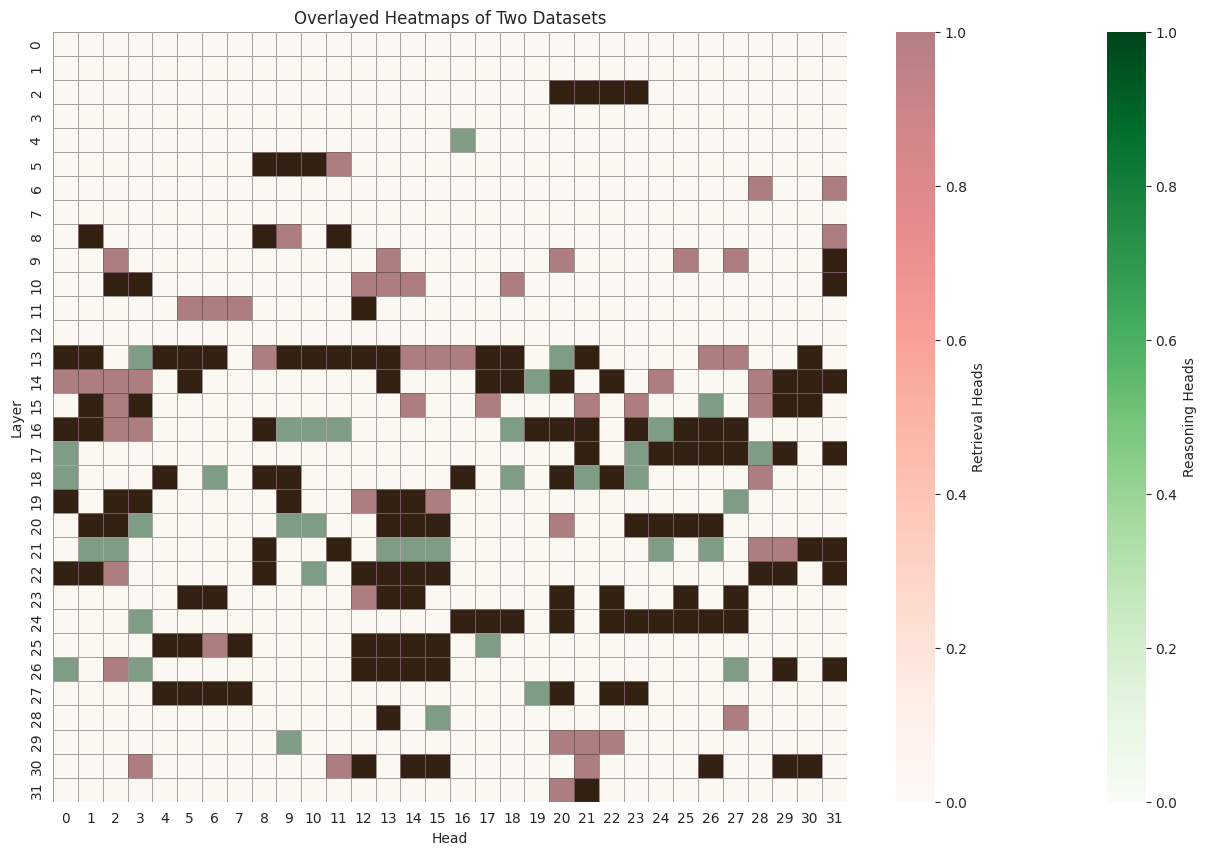

In [5]:
num_layers = 32
num_heads = 32
df_reason_scores = np.zeros((num_layers, num_heads))
df_retrieval_scores = np.zeros((num_layers, num_heads))

for key, values in reason_scores.items():
    layer, head = map(int, key.split('-'))
    df_reason_scores[layer, head] = np.mean(values)

for key, values in retrieval_scores.items():
    layer, head = map(int, key.split('-'))
    df_retrieval_scores[layer, head] = np.mean(values)

reasoning_heads = df_reason_scores > 0.1
retrieval_heads = df_retrieval_scores > 0.1

plt.figure(figsize=(16, 10))
sns.heatmap(reasoning_heads, cmap='Greens', alpha=1, cbar=True, 
            cbar_kws={'label': 'Reasoning Heads'}, linewidths=0.5, linecolor='gray')
sns.heatmap(retrieval_heads, cmap='Reds', alpha=0.5, cbar=True, 
            cbar_kws={'label': 'Retrieval Heads'}, linewidths=0.5, linecolor='gray')

plt.title('Overlayed Heatmaps of Two Datasets')
plt.xlabel('Head')
plt.ylabel('Layer')

plt.show()
